In [23]:
#Import some basic packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, auc, log_loss, precision_recall_curve, precision_score, recall_score, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.utils import resample #Bootstrapping
import statsmodels.regression as smr
import shap
#import tikzplotlib as tikz
import warnings
import time
import itertools

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (12,6)

In [10]:
#Import some causal-based /graphical packages
from causallearn.utils.cit import CIT #Causal Inference Test, for kernel-based CIT -> p-value
import cdt #causality discovery tools
import cdt.causality.graph.model as causal_model
from cdt.causality.graph.bnlearn import MMPC #Max-Min Parents-Children algorithm
from cdt.independence.graph import HSICLasso, DecisionTreeRegression
from cdt.metrics import precision_recall
from cdt.causality.graph.bnlearn import IAMB
from cdt.causality.graph import Inter_IAMB
from causallearn.search.FCMBased import lingam
import networkx as nx #graph theory
from cdt.utils.Settings import autoset_settings #Autoset GPU parameters using CUDA_VISIBLE_DEVICES variables.

### The data can be found $\to\href{https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data}{\textbf{ here}}$

In [11]:
data = pd.read_csv("data.csv").drop(['id', 'Unnamed: 32'], axis='columns')

pos_neg_encoder = LabelEncoder()
data['diagnosis'] = pos_neg_encoder.fit_transform(data['diagnosis']) #'M'-> 1 else 0

data

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [12]:
X = data.loc[:, data.columns != 'diagnosis']
y = data[['diagnosis']]



X_train, X_hold_out, y_train, y_hold_out = train_test_split(X, y,
                                                        stratify=y, 
                                                        test_size=0.25,
                                                        random_state=666)

train_data_labelized = pd.concat([X_train, y_train], axis=1)

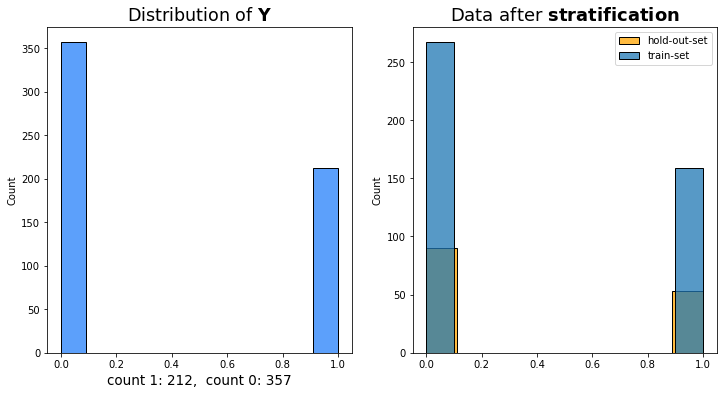

In [24]:
#stratification
if __name__ == '__main__':
    
    plt.subplot(1, 2, 1) #1-row, 2-column goes to 1
    sns.histplot(np.ravel(y), color=(0.15,0.5,0.98))
    plt.title('Distribution of $\mathbf{Y}$', size=17.5)
    plt.xlabel(f'count 1: {list(np.ravel(y)).count(1)},  count 0: {list(np.ravel(y)).count(0)}', size=13.5)
    
    
    plt.subplot(1, 2, 2) #1-row, 2-column goes to 2
    sns.histplot(np.ravel(y_hold_out), color='orange', edgecolor='black', label='hold-out-set')
    sns.histplot(np.ravel(y_train), label='train-set')
    plt.legend(loc='best')
    plt.title('Data after $\mathbf{stratification}$', size=18)
    
    plt.show()

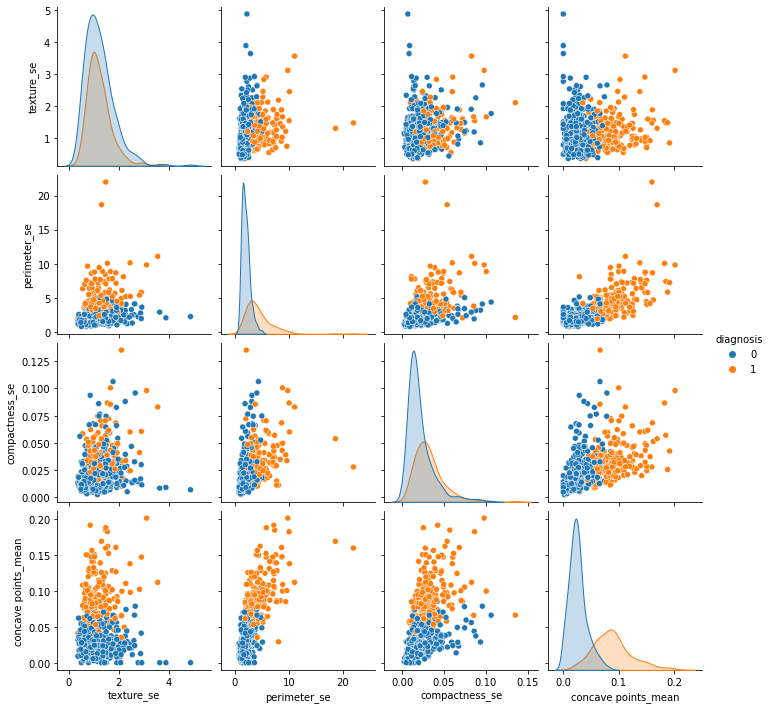

In [38]:
if __name__ == '__main__':
    sns.pairplot(data, hue="diagnosis",
                 vars=np.random.choice(X.columns.tolist(), 4))

    plt.show()

* Map $\texttt{feature_name_i}$ $\to$ $X_i$:

In [14]:
feature_names = data.columns[1:]
feature_transform = dict(zip((f'X{i}' for i in range(1,data.shape[0]+1)), feature_names))
feature_inv_transform = dict(zip(feature_names, (f'X{i}' for i in range(1,data.shape[0]+1))))

feature_inv_transform_f = lambda f: feature_inv_transform[f] #for mapping purposes later on

features_idx = tuple(feature_transform.keys())

X_train.columns = features_idx

------

* A better way to choose threshold for p-values:
## Bayes Factor (BF) $\le$ Bayes Factor Bound (BFB) $=\cfrac{1}{-e\cdot p\log(p)} $

In [5]:
BFB = lambda p: -1/(np.exp(1)*p*np.log(p))

#A p-value of 0.01 indicates the alternative hypothesis is at most 8 times as likely as the null
p = 0.01
BFB(p)

7.988400565320467

In [6]:
"""When the prior probabilities of H0 and H1 are equal, 
this upper bound on the posterior probability of H1 is given by:"""

PH1_p = lambda p: BFB(p)/(1+BFB(p)) #P^U (H1|p)

PH1_p(0.05)

0.7106501145388984

#### The following table shows the value of BFB for a wide range of p-values. For those who are more comfortable with posterior probabilities than odds, the table also gives the corresponding upper bound on the posterior probability:

Source: https://www.tandfonline.com/doi/full/10.1080/00031305.2018.1543135

In [7]:
p_thesholds = (0.1, 0.05, 0.01, 0.005, 0.001, 0.0001, 0.000010)
table = pd.DataFrame({
    'p-value':p_thesholds,
    'BFB': np.round(tuple(map(BFB, p_thesholds)), 2),
    '$P^U$($H_1$ | p-value)': np.round(tuple(map(PH1_p, p_thesholds)), 4)
})

def highlight_row(val):
    color = 'red' if val in table.loc[3] else 'green'
    return 'color: %s' % color

table.applymap(lambda x: str(x)).style.applymap(highlight_row, subset=pd.IndexSlice[3, :])

,p-value,BFB,$P^U$($H_1$ | p-value)
0,0.1,1.6,0.615
1,0.05,2.46,0.7107
2,0.01,7.99,0.8887
3,0.005,13.89,0.9328
4,0.001,53.26,0.9816
5,0.0001,399.42,0.9975
6,1e-05,3195.36,0.9997


# $\to\texttt{ Max-Min Parents-Children algorithm}$

Description: The $\texttt{Max-Min Parents-Children}$ (MMPC) is a 2-phase algorithm with a forward pass and a backward pass. The forward phase adds recursively the variables that possess the highest association with the target conditionally to the already selected variables. The backward pass tests d-separability of variables conditionally to the set and subsets of the selected variables.

Required R packages: $\texttt{bnlearn}$

Data Type: Depends on the test used. Check here for the list of available tests.

#### Assumptions: MMPC outputs $\texttt{Markov Blankets}$ of nodes, with additional assumptions depending on the conditional test used.



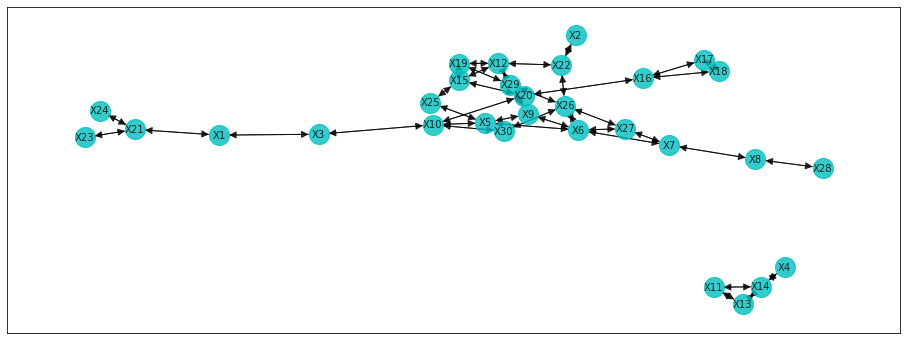

In [412]:
MMPC_obj = MMPC(alpha=0.005)

#The predict() method works without a graph, or with a
#directed or undirected graph provided as an input

MMPC_output = MMPC_obj.predict(X_train) #No graph provided as an argument

nx.draw_networkx(MMPC_output, font_size=10, alpha=0.8,
                 node_size=402, arrowsize=15, node_color='c', font_color='k')
plt.show()

#  $\to \texttt{ Graphical Decision Tree Regression}$

In [413]:
DTR = DecisionTreeRegression()
DT_output = DTR.predict_features(X_train, y_train)
DT_ugraph = DTR.predict(X_train)  # Predict skeleton

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [414]:
DT_output

array([0.        , 0.00896396, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00806757, 0.        , 0.        ,
       0.        , 0.01882432, 0.        , 0.02023408, 0.00806757,
       0.        , 0.        , 0.        , 0.        , 0.00174345,
       0.00717117, 0.03198433, 0.71546432, 0.0294317 , 0.01920849,
       0.        , 0.        , 0.12546065, 0.00537838, 0.        ])

In [415]:
# w1 * X1 + w2 * X2 + ... + w_30 * X30
wX = dict(((feature_i, weight) for (weight,feature_i) in zip(DT_output, data.columns[1:])))

wX_sorted = dict(sorted(wX.items(), key=lambda item: item[1], reverse=True))
wX_sorted

{'perimeter_worst': 0.7154643191763191,
 'concave points_worst': 0.125460648556292,
 'texture_worst': 0.0319843301613619,
 'area_worst': 0.029431704568320276,
 'area_se': 0.020234080484349284,
 'smoothness_worst': 0.01920849420849421,
 'texture_se': 0.018824324324324328,
 'texture_mean': 0.008963963963963966,
 'concave points_mean': 0.008067567567567569,
 'smoothness_se': 0.008067567567567569,
 'radius_worst': 0.0071711711711711715,
 'symmetry_worst': 0.0053783783783783795,
 'fractal_dimension_se': 0.001743449871890239,
 'radius_mean': 0.0,
 'perimeter_mean': 0.0,
 'area_mean': 0.0,
 'smoothness_mean': 0.0,
 'compactness_mean': 0.0,
 'concavity_mean': 0.0,
 'symmetry_mean': 0.0,
 'fractal_dimension_mean': 0.0,
 'radius_se': 0.0,
 'perimeter_se': 0.0,
 'compactness_se': 0.0,
 'concavity_se': 0.0,
 'concave points_se': 0.0,
 'symmetry_se': 0.0,
 'compactness_worst': 0.0,
 'concavity_worst': 0.0,
 'fractal_dimension_worst': 0.0}

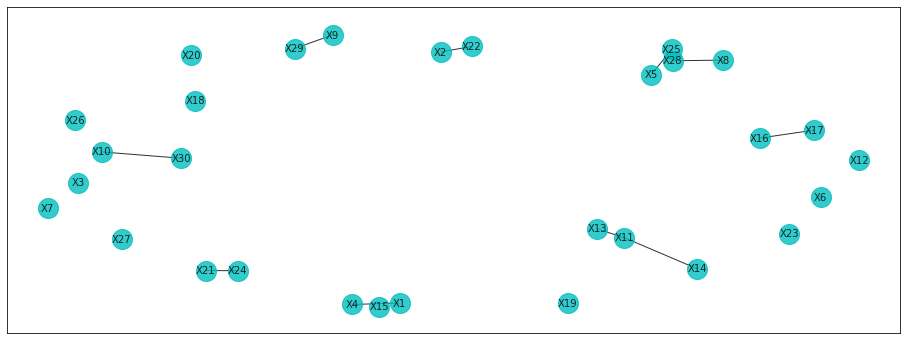

In [416]:
nx.draw_networkx(DT_ugraph, font_size=10, alpha=0.8,
                 node_size=402, arrowsize=15, node_color='c', font_color='k')
plt.show()

-----

# $\to\texttt{ Graphical Lasso with a kernel-based independence test}:$
Lasso aka Least Absolute Shrinkage and Selection Operator

Ref : Friedman, J., $\texttt{Hastie, T., & Tibshirani}$, R. (2008). Sparse inverse covariance estimation with the graphical lasso.

Biostatistics.

-----

In [6]:
KBLasso = HSICLasso()
L_output_ = KBLasso.predict_features(X_train, y_train)
L_ugraph = KBLasso.predict(X_train)  # Predict skeleton

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [418]:
L_output = L_output_[:,0]
wX_lasso = dict(((feature_i, weight) for (weight,feature_i) in zip(L_output, data.columns[1:])))

wX_lasso_sorted = dict(sorted(wX_lasso.items(), key=lambda item: item[1], reverse=True))

print(f'selected features: {len(np.where(L_output!=0)[0])}')
wX_lasso_sorted

selected features: 5


{'perimeter_worst': 0.44563069887860013,
 'concave points_worst': 0.28985122665794805,
 'concave points_mean': 0.18313330706173128,
 'radius_worst': 0.11554194907557788,
 'texture_worst': 0.04307624803742485,
 'radius_mean': 0.0,
 'texture_mean': 0.0,
 'perimeter_mean': 0.0,
 'area_mean': 0.0,
 'smoothness_mean': 0.0,
 'compactness_mean': 0.0,
 'concavity_mean': 0.0,
 'symmetry_mean': 0.0,
 'fractal_dimension_mean': 0.0,
 'radius_se': 0.0,
 'texture_se': 0.0,
 'perimeter_se': 0.0,
 'area_se': 0.0,
 'smoothness_se': 0.0,
 'compactness_se': 0.0,
 'concavity_se': 0.0,
 'concave points_se': 0.0,
 'symmetry_se': 0.0,
 'fractal_dimension_se': 0.0,
 'area_worst': 0.0,
 'smoothness_worst': 0.0,
 'compactness_worst': 0.0,
 'concavity_worst': 0.0,
 'symmetry_worst': 0.0,
 'fractal_dimension_worst': 0.0}

-----

* $\texttt{Precision}$ is defined by: `Pr=tp/(tp+fp)` and directly denotes the total classification accuracy given a confidence threshold. On the other hand,

* $\texttt{Recall}$ is defined by: `Re=tp/(tp+fn)` and denotes misclassification given a threshold.

-----

# $\to \texttt{ IAMB algorithm}$

Description: The is a $\texttt{bayesian constraint based}$ algorithm to recover $\texttt{Markov blankets}$ in a forward selection and a modified backward selection process.

Required R packages: $\texttt{bnlearn}$

Data Type: Depends on the test used. Check here for the list of available tests.

Assumptions: IAMB outputs Markov blankets of nodes, with additional assumptions depending on the conditional test used.

Note: `Tsamardinos I, Aliferis CF, Statnikov A (2003). “Algorithms for Large Scale Markov Blanket Discovery”. In “Proceedings of the Sixteenth International Florida Artificial Intelligence Research Society Conference”, pp. 376-381. AAAI Press.`

Source: $\href{http://www.jcomputers.us/vol5/jcp0511-18.pdf}{\textbf{Algorithms for Large Scale Markov Blanket Discovery } \text{: Ioannis Tsamardinos, Constantin F. Aliferis, Alexander Statnikov}}$


In [419]:
IAMB_alg = IAMB(alpha=0.005)

iamb_output = IAMB_alg.predict(X_train)   #No graph provided as an argument


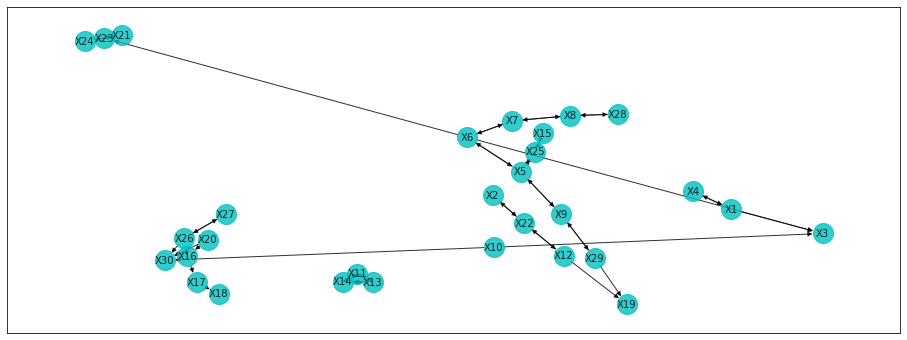

In [420]:
nx.draw_networkx(iamb_output, font_size=10, alpha=0.8,
                 node_size=400, arrowsize=9, node_color='c', font_color='k')
plt.show()

-----

# $\texttt{Interleaved IAMB algorithm}$

Description: Similar to IAMB, $\texttt{Interleaved-IAMB}$ has a progressive forward selection $\textbf{minimizing false positives}$.

Required R packages: $\texttt{bnlearn}$

Data Type: Depends on the test used. Check here for the list of available tests.

Assumptions: Inter-IAMB outputs markov blankets of nodes, with additional assumptions depending on the conditional test used.

----

In [421]:
IN_IAMB_alg = Inter_IAMB(alpha=0.005)

int_iamb_output = IN_IAMB_alg.predict(X_train)


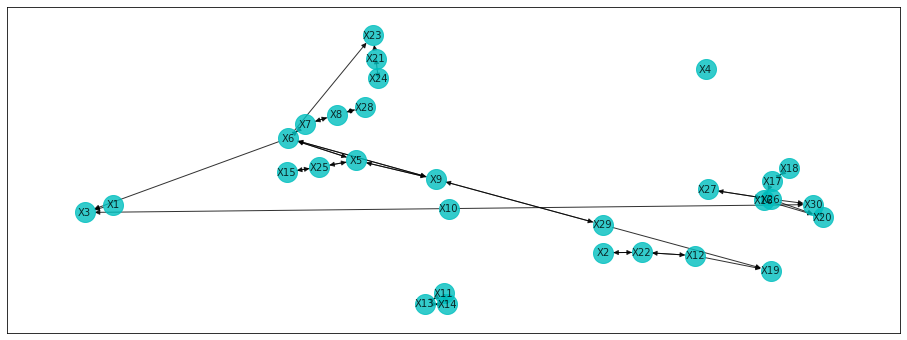

In [422]:
nx.draw_networkx(int_iamb_output, font_size=10, alpha=0.8,
                 node_size=400, arrowsize=10, node_color='c', font_color='k')
plt.show()

In [423]:
model = lingam.VARLiNGAM(criterion='aic')
model.fit(X_train)
#model.residuals_

print(f'Causal order: {model.causal_order_}')

Causal order: [29, 20, 1, 22, 8, 27, 14, 19, 25, 16, 23, 15, 4, 5, 28, 26, 9, 21, 11, 13, 10, 3, 24, 0, 17, 7, 18, 12, 6, 2]


----

# $\to\texttt{ Forward-Backward stepwise selection}$
$\texttt{With kernel-based conditional independence test}$
### $\big($ source: $\href{https://www.jmlr.org/papers/volume20/17-334/17-334.pdf}{\textbf{ Forward-Backward Selection with Early Dropping }}\big)$


-----

In [424]:

if __name__=='__main__':
    V_indices = np.arange(X_train.shape[1])
    T_idx = 30  #target
    V_idx = np.array(feature_names)
    
    

def stat_test(D, V_idx, T_idx, S=None):
    kci_obj = CIT(D, "kci")  # construct a CIT instance with data and method name
    pValue = kci_obj(V_idx, T_idx, S)
    return pValue

#The above code runs KCI (Kernel-based conditional independence) with the default parameters. 



def set_minus(target_set: np.array, subset: np.array):  #works with lists also
    
    target_set, subset = set(list(target_set)), set(list(subset))
    
    return np.array(list(target_set - subset))

S_changes = lambda S, S_prev : True if S!=S_prev or len(S)==0 else False #brake the loop if S changes
    



def forward_selection(D: np.array, V_indices: np.array, T_idx: int,
                      S: list, a: int = 0.005, show_progress: bool = None): # S=[], def.a=0.05
    if show_progress: print('Forward phase!\n\n')
    
        
    S_prev = [] #Set of selected variables: ø
    R = set_minus(V_indices, S) #Remaining Variables
    k = 1; #loop counter
    
    
    #Forward phase: iterate until S does not change
    while S_changes(S, S_prev):
        
        if show_progress: print(f'loop : {k}\n') #starting the loop message
            
        ########  main: ########
        
        S_prev = S.copy() #keep a copy of S
        
        #Identify V^∗ with min p-value given S
        V_star = R[np.argmin([stat_test(D, V, T_idx, S) for  V in R])] #X, Y cannot be in condition_set.
        
         
        #Remove V^∗ from R
        R = set_minus(R, [V_star]) #Remaining Variables

        if stat_test(D, V_star , T_idx, S) <= a:
            
            S.extend([V_star]) # S <- S U V^*  #update variables
            
            if show_progress: print(f'-> S = {S}\n')
        
        k += 1
        
    else:
        if show_progress: print(10*'-', ' S remained the same! ', 10*'-') #ending messege
        
    return S




def backward_selection(D: np.array, T_idx: int, S: list, a: int = 0.005, show_progress: bool = None):
    if show_progress: print('Backward phase!\n\n')
    S = list(S)
    
    S_prev = S.copy()
    k = 1 # counter of loop
    
    if show_progress: print(f'--->\tinitial S:\n\n{S_prev}\n\n')
        
        
    while S_changes(list(S), list(S_prev)) or k==1: # k <- 1: allows the first loop
        S_prev = list(S.copy())
        
        if show_progress: print(f'loop : {k}\n') #starting the loop message
        
        
        #Identify V^∗ with max p-value given S \ V (worst)
        V_star = S[np.argmax([stat_test(D, V, T_idx, set_minus(S, [V])) for V in S])]
        
        #Remove V^* if independent
        if stat_test(D, V_star , T_idx, set_minus(S, [V_star])) > a:
            
            S = set_minus(S, [V_star]) # S <- S \ V^*  #update variables
            
            if show_progress: print(f'-> S = {list(S)}\n')
        
        k+=1
        
    else:
        if show_progress: print(10*'-', ' S remained the same! ', 10*'-') #ending messege
        
    return S

In [425]:
forward_features = forward_selection(np.array(train_data_labelized),
                                     V_indices, T_idx, S=[], show_progress=True) #threshold a=0.005


Forward phase!


loop : 1

-> S = [0]

loop : 2

-> S = [0, 24]

loop : 3

-> S = [0, 24, 21]

loop : 4

-> S = [0, 24, 21, 23]

loop : 5

----------  S remained the same!  ----------


In [426]:
backward_features = backward_selection(D=np.array(train_data_labelized), T_idx=T_idx,
                                       S=forward_features, show_progress=True) #a=0.005

Backward phase!


--->	initial S:

[0, 24, 21, 23]


loop : 1

-> S = [24, 21, 23]

loop : 2

----------  S remained the same!  ----------


In [427]:
if __name__ == '__main'
    print(sorted(backward_features))
    print(f'\nFeatures selected by forward-backward selection (p-value threshold: 0.005 (NOT 0.05)): \n\n{V_idx[backward_features]}')

[21, 23, 24]

Features selected by forward-backward selection (p-value threshold: 0.005 (NOT 0.05)): 

['smoothness_worst' 'texture_worst' 'area_worst']


In [428]:
from_graph_to_pairs = lambda Graph: [(u, v) for u, v in int_iamb_output.edges()]

In [429]:
###The following function was implemented by me (source: I. Tsamardinos pseudocode)

def MMPC(data: pd.DataFrame, target: str, k:int = 2, alpha:int = 0.05, show_progress: bool = None): 
    
    T = tuple(data.columns).index(target) #index of target
    V = list(map(lambda x: data.columns.tolist().index(x),
                 data.loc[:, data.columns != 'diagnosis'].columns.tolist())) #indexes of features
    
    S_prev = []; S = [] #empty set

    R = V #begin with all the features
    loop = 1
        
            
    while S_changes(list(S), list(S_prev)):
        if show_progress: print(f'loop : {loop}\n') #starting the loop message
            
        S_prev = S.copy() #keep a copy of S

        #maximum p-values over subset Z of S with size <= k (note: default k <- 2)
        Z = [list(subset) for i in range(1, k+1) for subset in itertools.combinations(S, i)]
        if show_progress: print(f'Subsets Z of S: {Z} (of size k<={k})\n')
        
        if len(Z) == 0: #We check if Z is empty in order to condition on that set, otherwise cond for all subsets
            MaxPvalueTV = [stat_test(np.array(data), v, T, Z) for v in R]
        else:
            MaxPvalueTV = [stat_test(np.array(data), v, T, Zi) for v in R for Zi in Z]
        
        #identify V* with minimum MaxPvalue
        if len(Z)!=0:
            V_star = R[np.argmin([max([[stat_test(np.array(data), v, T, Zi) for  v in R] for Zi in Z])])]
        else:
            V_star = R[np.argmin([stat_test(np.array(data), v, T, Z) for  v in R])]
            

        #remove V_star from R:
        R = set_minus(R, [V_star])
        
        #remove from R if independent given some Z subset of S
        if_independents = []
        for i, v in enumerate(R):
            if MaxPvalueTV[i] > alpha:
                if_independents.append(v)
        
        #remove from R
        R = set_minus(R, if_independents)

        #select V* if dependent
        if len(Z)!=0:
            MaxPvalueTV_star = max([stat_test(np.array(data), V_star, T, Zi) for Zi in Z])
        else:
            MaxPvalueTV_star = stat_test(np.array(data), V_star, T, Z)

        if MaxPvalueTV_star <= alpha:
            S.extend([V_star]) # S <- S U V^*  #update variables
            
            if show_progress: print(f'-> S = {list(S)}\n')
                
        loop += 1
        
    else:
        if show_progress: print(10*'-', ' S remained the same! ', 10*'-') #ending messege  
        
        
    return S

In [430]:
MMPC_output_k3 = MMPC(train_data_labelized, 'diagnosis', alpha=0.005,
                   k=3, show_progress=True) #markov blanket or a subset of it

loop : 1

Subsets Z of S: [] (of size k<=3)

-> S = [0]

loop : 2

Subsets Z of S: [[0]] (of size k<=3)

-> S = [0, 24]

loop : 3

Subsets Z of S: [[0], [24], [0, 24]] (of size k<=3)

-> S = [0, 24, 21]

loop : 4

Subsets Z of S: [[0], [24], [21], [0, 24], [0, 21], [24, 21], [0, 24, 21]] (of size k<=3)

-> S = [0, 24, 21, 23]

loop : 5

Subsets Z of S: [[0], [24], [21], [23], [0, 24], [0, 21], [0, 23], [24, 21], [24, 23], [21, 23], [0, 24, 21], [0, 24, 23], [0, 21, 23], [24, 21, 23]] (of size k<=3)

----------  S remained the same!  ----------


In [431]:
MMPC_output_k2 = MMPC(train_data_labelized, 'diagnosis', alpha=0.005,
                   k=2, show_progress=True) #markov blanket or a subset of it

loop : 1

Subsets Z of S: [] (of size k<=2)

-> S = [0]

loop : 2

Subsets Z of S: [[0]] (of size k<=2)

-> S = [0, 24]

loop : 3

Subsets Z of S: [[0], [24], [0, 24]] (of size k<=2)

-> S = [0, 24, 21]

loop : 4

Subsets Z of S: [[0], [24], [21], [0, 24], [0, 21], [24, 21]] (of size k<=2)

----------  S remained the same!  ----------


In [432]:
MMPCk2 = feature_names[MMPC_output_k2].tolist()
MMPCk3 = feature_names[MMPC_output_k3].tolist()

if __name__ == '__main__':
    print(f'-> Max-Min Parent-Childern features selected (k <- {2}):\n\n {MMPCk2}\n\t or\n{list(map(feature_inv_transform_f, MMPCk2))}\n\n')
    print(f'-> Max-Min Parent-Childern features selected (k <- {3}):\n\n {MMPCk3}\n\t or\n{list(map(feature_inv_transform_f, MMPCk3))}')

-> Max-Min Parent-Childern features selected (k <- 2):

 ['radius_mean', 'smoothness_worst', 'texture_worst']
	 or
['X1', 'X25', 'X22']


-> Max-Min Parent-Childern features selected (k <- 3):

 ['radius_mean', 'smoothness_worst', 'texture_worst', 'area_worst']
	 or
['X1', 'X25', 'X22', 'X24']


In [433]:
mmpc3_nodes = [list(filter(lambda pair_i: MMPCk3i  in pair_i, from_graph_to_pairs(MMPC_output)))
                            for MMPCk3i in list(map(feature_inv_transform_f, MMPCk3))]
#mmpc3_nodes

In [434]:
mmpc2_nodes = [list(filter(lambda pair_i: MMPCk2i  in pair_i, from_graph_to_pairs(MMPC_output)))
                            for MMPCk2i in list(map(feature_inv_transform_f, MMPCk2))]
#mmpc2_nodes

In [435]:
mmpc2_graph = [node[i] for node in mmpc2_nodes for i in range(len(node))]
mmpc3_graph = [node[i] for node in mmpc3_nodes for i in range(len(node))]


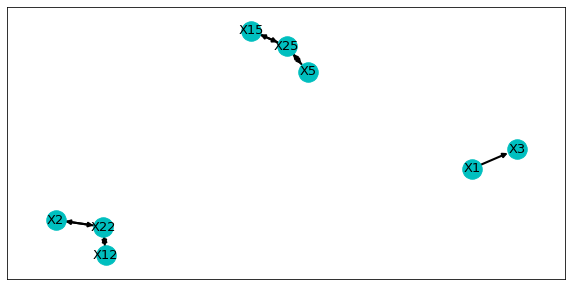

In [436]:
plt.rcParams["figure.figsize"] = (10,5)

G_2 = nx.DiGraph()
G_2.add_edges_from(mmpc2_graph)

G_3 = nx.DiGraph()
G_3.add_edges_from(mmpc3_graph)

options = {
    'node_color': 'c',
    'node_size': 150,
    'width': 2.1,
    'arrowstyle': '-|>',
    'arrowsize': 9,
    'node_size': 379,
    'font_size': 13
}

nx.draw_networkx(G_2, cmap = plt.get_cmap('jet'), arrows=True, **options)
plt.show()

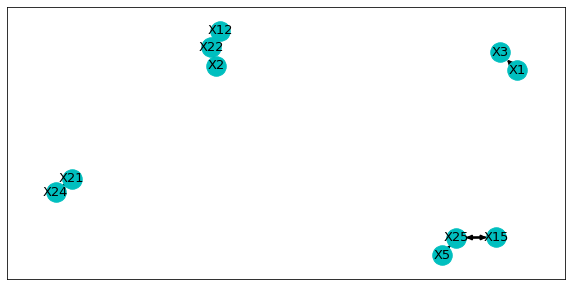

In [437]:
nx.draw_networkx(G_3, cmap = plt.get_cmap('jet'), arrows=True, **options)
plt.show()

## $\to$ Forward stepwise logistic selection using AIC, AICc, BIC NOT p-values



------

# $\bullet$ Forward-Stepwise-Selection


For computational reasons, the best subset cannot be applied for any large $n$
 due to the $2^n$
 complexity. Forward Stepwise begins with a model containing no predictors, and then adds predictors to the model, one at the time. At each step, the variable that gives the greatest additional improvement to the fit is added to the model.
 
## Algorithm:

1. Let $M_0$ denote the null model, which contains no predictors.

2. For $k=0,...,p−1$:

$\phantom{....}$(a) Consider all $p − k$ models that augment the predictors in $M_k$
with one additional predictor.

$\phantom{....}$(b) Choose the best among these $p − k$ models, and call it $M_{k+1}$.
best is defined as having highest $\textbf{AUC}$ (smallest RSS, highest $R^2$ or an equivalent measure)

3. Select a single best model from among $M_0, . . . , M_p$ using cross-validated prediction error, $C_p$ (AIC, $\textbf{AICc}), \textbf{BIC}$, or adjusted $R^2$.


------

### Recall: $\mathbf{AIC_c} = \mathbf{AIC}+\cfrac{2p(p+1)}{n-p-1} =−2\log(\mathcal L)+2p+\cfrac{2p(p+1)}{n-p-1}$


$\to$ Though forward stepwise selection considers p(p + 1)/2 + 1 models, it performs a guided search over model space, and so the effective model space considered contains substantially more than p(p + 1)/2 + 1 models.


In [736]:
X_train.columns = tuple(data.columns)[1:] #return to original feature names


def forward_stepwise_logistic_selection(data: pd.DataFrame, target: str, info: bool = None):
    X = data.loc[:, data.columns != target]
    y = data[[target]]
    
    feature_names = X.columns
    best_feature_each = [None]
    best_feature_list = [best_feature_each] #start with the null model
    add_best = []

    M_k = []

    p = len(feature_names)


    for k in range(p):
        loop = 1
        all_step_aucs = [] ; index_name = []
        add_best = best_feature_list  # FSS features so far
        
        
        if info: print(f'\n-> p-k = {p-k} models\n\n')



        for i in range(len(feature_names)):  #Consider all p-k models that augment the predictors in M_k
                                             #with one additional predictor

            if feature_names[i] in add_best:
                continue


            sub_f = add_best + [feature_names[i]]


            if k==0:
                sub_f = [feature_names[i]]

            if info:
                print(f'############  inner loop:{loop} (model_{loop})  ############:\n')
                print(f'-> for k={k}:\ttrain on subset: {sub_f}\n')
                print(f'-> index of {feature_names[i]} : {i} .')

            """hyperparameter = (0.025,0.05,0.1,0.5,1,5,10)
            ##in RidgeCV, 'scorer' is only used to choose best hyperparameters
            ##(set self.alpha_ and self.dual_coef_ attributes).
            RLR_cls = RidgeCV(alphas=hyperparameter, cv=6, 
                         gcv_mode='auto',scoring='roc_auc').fit(X[sub_f], np.ravel(y)) #StratifiedKFold"""
        
            ridge_cls = LogisticRegression(penalty='l2', solver= 'lbfgs')
            X_sub_scaled = StandardScaler().fit(X[sub_f]).transform(X[sub_f]) #standardize the data
            
            auc_scores = cross_val_score(ridge_cls, X_sub_scaled, y, cv=5,
                                         scoring='roc_auc')
                                         
            ridge_cls.fit(X_sub_scaled, np.ravel(y))
            
            
            #auc_scores = cross_val_score(RLR_cls, X[sub_f], y, cv=8,
            #                 scoring='roc_auc')

            all_step_aucs.append(np.mean(auc_scores)) #average AUC on StratifiedKFold CV of p-k models
            #all_step_aucs.append(RLR_cls.best_score_) #average AUC on StratifiedKFold CV of p-k models
            index_name.append(feature_names[i])       
            
            if info:
                print(f'\n-> Average AUC on CV = {np.mean(all_step_aucs):.5f} .\n\n')

            loop += 1

        best_feature_each = index_name[np.argmax(all_step_aucs)] #feature that augment Mk  
        best_feature_list.append(best_feature_each)
        
        if info:
            print(f'---> BEST FEATURE SELECTED : {best_feature_each}\n\n')
            print(69*'_')

        if k==0:
                add_best.pop(0) #remove the null model in order to train later on

        features_MK = add_best.copy()


        M_k_classifier = ridge_cls.fit(X[features_MK], np.ravel(y))
        M_k.append([features_MK, M_k_classifier])
    
    return M_k


AICc = lambda AIC, n, K: AIC + (2*K*(K+1))/(n-K-1)


def best_AICc(data: pd.DataFrame, M_k: list, all_aic: bool = None,
              criterion: str = None):
    
    X = data.loc[:, data.columns != 'diagnosis']
    y = data[['diagnosis']]
    
    n = X.shape[0] #samples size
    M_k_model_AIC = []
    Keys = ['AICc (1 predictor)']+[f'AICc ({i} predictors)' for i in range(2,30+1)]

        
    for i in range(len(M_k)):
        
        #add constant to predictor variables
        X_ = sm.add_constant(X)
       
        X_M_0_scaled = StandardScaler().fit(X_[M_k[i][0]]).transform(X_[M_k[i][0]])
        model_i = smr.linear_model.OLS(np.ravel(y), X_M_0_scaled).fit()

        
        k = len(M_k[i][0])
        
        if criterion == 'BIC':
            M_k_model_AIC.append(int(model_i.bic))
            Keys = ['BIC (1 predictor)']+[f'BIC ({i} predictors)' for i in range(2,30+1)]    

        else:
            M_k_model_AIC.append(int(AICc(model_i.aic, n, k)))
        
    final_features = M_k[np.argmin(M_k_model_AIC)][0]
    
    if all_aic:
        print(dict(zip(Keys, M_k_model_AIC)))
        return;
        
    return final_features #returns the model with the < AICc




#se info -> True in order to show the progress
FSL_Mk = forward_stepwise_logistic_selection(train_data_labelized,
                                             target='diagnosis') #p models (best among these p − k models)

In [567]:
best_AICc(train_data_labelized, FSL_Mk, all_aic=True)

{'AICc (1 predictor)': 589, 'AICc (2 predictors)': 571, 'AICc (3 predictors)': 555, 'AICc (4 predictors)': 554, 'AICc (5 predictors)': 554, 'AICc (6 predictors)': 554, 'AICc (7 predictors)': 556, 'AICc (8 predictors)': 552, 'AICc (9 predictors)': 550, 'AICc (10 predictors)': 551, 'AICc (11 predictors)': 548, 'AICc (12 predictors)': 548, 'AICc (13 predictors)': 549, 'AICc (14 predictors)': 550, 'AICc (15 predictors)': 552, 'AICc (16 predictors)': 554, 'AICc (17 predictors)': 556, 'AICc (18 predictors)': 557, 'AICc (19 predictors)': 558, 'AICc (20 predictors)': 556, 'AICc (21 predictors)': 558, 'AICc (22 predictors)': 558, 'AICc (23 predictors)': 560, 'AICc (24 predictors)': 559, 'AICc (25 predictors)': 561, 'AICc (26 predictors)': 562, 'AICc (27 predictors)': 562, 'AICc (28 predictors)': 564, 'AICc (29 predictors)': 566, 'AICc (30 predictors)': 566}


In [568]:
best_AICc(train_data_labelized, FSL_Mk, all_aic=True, criterion='BIC')

{'BIC (1 predictor)': 593, 'BIC (2 predictors)': 579, 'BIC (3 predictors)': 567, 'BIC (4 predictors)': 570, 'BIC (5 predictors)': 574, 'BIC (6 predictors)': 578, 'BIC (7 predictors)': 584, 'BIC (8 predictors)': 584, 'BIC (9 predictors)': 586, 'BIC (10 predictors)': 591, 'BIC (11 predictors)': 592, 'BIC (12 predictors)': 596, 'BIC (13 predictors)': 601, 'BIC (14 predictors)': 606, 'BIC (15 predictors)': 612, 'BIC (16 predictors)': 617, 'BIC (17 predictors)': 623, 'BIC (18 predictors)': 628, 'BIC (19 predictors)': 633, 'BIC (20 predictors)': 635, 'BIC (21 predictors)': 640, 'BIC (22 predictors)': 645, 'BIC (23 predictors)': 651, 'BIC (24 predictors)': 654, 'BIC (25 predictors)': 659, 'BIC (26 predictors)': 664, 'BIC (27 predictors)': 668, 'BIC (28 predictors)': 674, 'BIC (29 predictors)': 679, 'BIC (30 predictors)': 683}


In [572]:
final_features_fs = best_AICc(train_data_labelized, FSL_Mk)
print(100*'_',
      f'\n\n-> Final features selected by forward stepwise regression (via AICc):\n\n{final_features_fs}\
             \n\n-> size of features : {len(final_features_fs)} .')


final_features_bic = best_AICc(train_data_labelized, FSL_Mk, criterion='BIC')

print(100*'_',
      f'\n\n-> Final features selected by forward stepwise RidgeCV regression (via BIC):\n\n{final_features_bic}\
             \n\n-> size of features : {len(final_features_bic)} .\n', 100*'_')

____________________________________________________________________________________________________ 

-> Final features selected by forward stepwise regression (via AICc):

['perimeter_worst', 'concave points_mean', 'texture_worst', 'smoothness_mean', 'perimeter_se', 'texture_se', 'fractal_dimension_se', 'concave points_worst', 'radius_se', 'area_mean', 'area_se']             

-> size of features : 11 .
____________________________________________________________________________________________________ 

-> Final features selected by forward stepwise RidgeCV regression (via BIC):

['perimeter_worst', 'concave points_mean', 'texture_worst']             

-> size of features : 3 .
 ____________________________________________________________________________________________________


In [570]:
forward_stepwise_logistic_features_BIC = best_AICc(train_data_labelized, FSL_Mk, criterion='BIC')
forward_stepwise_logistic_features_BIC

['perimeter_worst', 'concave points_mean', 'texture_worst']

In [571]:
forward_stepwise_logistic_features_AICc = best_AICc(train_data_labelized, FSL_Mk)
forward_stepwise_logistic_features_AICc

['perimeter_worst',
 'concave points_mean',
 'texture_worst',
 'smoothness_mean',
 'perimeter_se',
 'texture_se',
 'fractal_dimension_se',
 'concave points_worst',
 'radius_se',
 'area_mean',
 'area_se']

# $\bullet$ Create a class for each Feature Selection alogirthm

In [7]:

#Create a class of MMPC selection algorithm
class MMPCSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k: int = 2, alpha: float = 0.005):
        self.k = k
        self.alpha = alpha 

    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        target = y.columns[0]
        self.feature_indices_ = MMPC(data, target, self.k, self.alpha, show_progress=False)
        return self

    def transform(self, X):
        self.featuresDF = X.iloc[:, self.feature_indices_]
        return self.featuresDF
    
    def get_feature_names_out(self):
        return self.featuresDF.columns.tolist()


class  StandardScalerDF:
    def __init__(self, with_mean: bool = True, with_std: bool = True):
        self.with_mean = with_mean
        self.with_std = with_std
        
    def fit(self, data):
        self.scaler = StandardScaler(copy=True, with_mean=self.with_mean, with_std=self.with_std).fit(data)
        return self.scaler
    
    def transform(self, data):
        return pd.DataFrame(self.scaler.transform(data), columns=data.columns,
                            index=data.index)
    

class Kernel_Based_LASSO(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y):
        KBLasso = HSICLasso()
        self.feature_indices_ = np.where(KBLasso.predict_features(X, y)!=0)[0].tolist() #idx of sel. feature
        self.feature_names_ = X.columns[self.feature_indices_].tolist()
        return self

    def transform(self, X):
        self.featuresDF = X.iloc[:, self.feature_indices_]
        return self.featuresDF
    
    def get_feature_names_out(self):
        return self.featuresDF.columns.tolist()
    
    
class Forward_Backward_Selection(BaseEstimator, TransformerMixin):
    
    def __init__(self, alpha: float = 0.005):
        self.alpha = alpha
        
    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        target = y.columns[0]
        T_idx = tuple(data.columns).index(target)
        V_indices = np.arange(X.shape[1])
        
        forward_part = forward_selection(np.array(data),
                                         V_indices, T_idx, S=[], a=self.alpha)

        
        backward_part = backward_selection(D=np.array(data), T_idx=T_idx,
                                           S=forward_part, a=self.alpha)
        
        self.feature_indices_ = backward_part
        
        return self
    
    
    def transform(self, X):
        self.featuresDF = X.iloc[:, self.feature_indices_]
        return self.featuresDF
    
    def get_feature_names_out(self):
        return self.featuresDF.columns.tolist()
        

class Forward_Stepwise_Selection(BaseEstimator, TransformerMixin):
    
    def __init__(self, criterion: str = 'BIC'): #Alternative choice: AICc
        self.criterion = criterion
    
    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        target = y.columns[0]
        Mk = forward_stepwise_logistic_selection(data, target)
        
        if self.criterion == 'AICc':
            self.feature_indices_ = best_AICc(data, FSL_Mk, criterion='AICc')
        else:
            self.feature_indices_ = best_AICc(data, FSL_Mk, criterion='BIC')
            
        return self
    
    def transform(self, X):
        self.featuresDF = X[self.feature_indices_]
        return self.featuresDF
    
    def get_feature_names_out(self):
        return self.featuresDF.columns.tolist()
        


In [815]:
#We create a pipeline for each feature selection algorithm and we Standarise the data.

FSLS_pipe = Pipeline([
    ('Forward_stepwise', Forward_Stepwise_Selection()), #AICc/BIC
    ('Scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='saga', random_state=69))
    ])

FSLS_grid_param = {
    'Forward_stepwise__criterion': ('AICc', 'BIC'),
    'classifier__C': (1/0.1, 1, 1/5, 1/10),
    'classifier__penalty': ('l1', 'l2', 'elasticnet')
    }




FB_pipe = Pipeline([
    ('Forward_Backward', Forward_Backward_Selection()), #p-values
    ('Scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='saga', random_state=69))
    ])

FB_grid_param = {
    'classifier__C': (1/0.1, 1, 1/5, 1/10),
    'classifier__penalty': ('l1', 'l2', 'elasticnet')
    }




MMPC_pipe = Pipeline([
    ('MMPC', MMPCSelector()), #p-values
    ('Scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='saga', random_state=69))
    ])

MMPC_grid_param = {
    'MMPC__k': (2, 3, 4), # Subsets of size <= k
    'classifier__C': (1/0.1, 1, 1/5, 1/10),
    'classifier__penalty': ('l1', 'l2', 'elasticnet')

    }



GraphLASSO_pipe = Pipeline([
    ('Graph_LASSO', Kernel_Based_LASSO()),
    ('Scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='saga', random_state=69))
    ])

GraphLASSO_grid_param = {
    'classifier__C': (1/0.1, 1, 1/5, 1/10),
    'classifier__penalty': ('l1', 'l2', 'elasticnet') #lasso, ridge, ElasticNet
    }

#Note 'saga'  fast convergence is only guaranteed on features with approximately the same scale, 
#that why we have to scale things.


In [816]:
t1 = time.time() #start counting

#Fit the GridSearch for each pipeline

FSLS_grid = GridSearchCV(FSLS_pipe, FSLS_grid_param,
                         cv=5, scoring='roc_auc')
FSLS_grid.fit(X_train, y_train)



FB_grid = GridSearchCV(FB_pipe, FB_grid_param,
                       cv=5, scoring='roc_auc')
FB_grid.fit(X_train, y_train)



MMPC_grid = GridSearchCV(MMPC_pipe, MMPC_grid_param,
                         cv=5, scoring='roc_auc')
MMPC_grid.fit(X_train, y_train)



GraphLASSO_grid = GridSearchCV(GraphLASSO_pipe, GraphLASSO_grid_param,
                               cv=5, scoring='roc_auc')
GraphLASSO_grid.fit(X_train, y_train)


t2 = time.time() #stop #its gonna take a while! ≈ 4hours

In [817]:
seconds = abs(t2-t1)

minutes, seconds = divmod(seconds, 60)
hours, minutes = divmod(minutes, 60)

print(f'time needed : {int(hours)} hours : {int(minutes)} minutes : {np.floor(seconds):.0f} sec')

time needed : 14 hours : 22 minutes : 0 sec


In [1174]:
GraphLASSO_best_model = GraphLASSO_grid.best_estimator_
GraphLASSO_features = GraphLASSO_best_model.named_steps['Graph_LASSO'].get_feature_names_out()


MMPC_best_model = MMPC_grid.best_estimator_
MMPC_features = MMPC_best_model.named_steps['MMPC'].get_feature_names_out()


FB_best_model= FB_grid.best_estimator_
FB_features = FB_best_model.named_steps['Forward_Backward'].get_feature_names_out()


best_model_FSLS = FSLS_grid.best_estimator_
FSLS_features = best_model_FSLS.named_steps['Forward_stepwise'].get_feature_names_out()


#Jad's feature selected
JadBios_FS = ['perimeter_worst', 'texture_worst', 'concavity_mean',
              'smoothness_worst', 'metry_worst']


In [1374]:
if __name__ == '__main__':
    print(f'Features selected by Graphical LASSO:\n\n{GraphLASSO_features}\n\n')
    print(f'Features selected by MMPC:\n\n{MMPC_features}\n\n')
    print(f'Features selected by Forward-Backward:\n\n{FB_features}\n\n')
    print(f'Features selected by Forward-stepwise:\n\n{FSLS_features}\n\n')
    print(f'Features selected by JadBio:\n\n{JadBios_FS}\n\n')


Features selected by Graphical LASSO:

['concave points_mean', 'radius_worst', 'texture_worst', 'perimeter_worst', 'concave points_worst']


Features selected by MMPC:

['radius_mean', 'smoothness_worst', 'texture_worst']


Features selected by Forward-Backward:

['smoothness_worst', 'texture_worst', 'area_worst']


Features selected by Forward-stepwise:

['perimeter_worst', 'smoothness_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'perimeter_se', 'fractal_dimension_worst', 'radius_se']


Features selected by JadBio:

['perimeter_worst', 'texture_worst', 'concavity_mean', 'smoothness_worst', 'metry_worst']




In [1373]:
"""In binary classification is preferable to use the "roc_auc" metric, 
the best_score_ attribute will return the mean cross-validated (AUC-ROC) of the
best estimator found by the GridSearchCV across all folds and all hyperparameter combinations."""

if __name__ == '__main__':
    print(f'For Graphical LASSO -> mean cross-validated roc_AUC:\t      {GraphLASSO_grid.best_score_:.3f}')
    print(f'For MMPC -> mean cross-validated roc_AUC:\t\t      {MMPC_grid.best_score_:.3f}')
    print(f'For Forward-Backward -> mean cross-validated roc_AUC:\t      {FB_grid.best_score_:.3f}')
    print(f'For Forward-Stepwise (Ridge) -> mean cross-validated roc_AUC: {FSLS_grid.best_score_:.3f}')


For Graphical LASSO -> mean cross-validated roc_AUC:	      0.989
For MMPC -> mean cross-validated roc_AUC:		      0.983
For Forward-Backward -> mean cross-validated roc_AUC:	      0.984
For Forward-Stepwise (Ridge) -> mean cross-validated roc_AUC: 0.995


In [1372]:
if __name__ == '__main__':
    print(f'For Graphical LASSO best Hyperparameters {GraphLASSO_grid.best_params_}\n\n')
    print(f'For MMPC best Hyperparameters {MMPC_grid.best_params_}\n\n')
    print(f'For Forward-Backward best Hyperparameters {FB_grid.best_params_}\n\n')
    print(f'For Forward-Stepwise best Hyperparameters {FSLS_grid.best_params_}\n\n')

For Graphical LASSO best Hyperparameters {'classifier__C': 1, 'classifier__penalty': 'l2'}


For MMPC best Hyperparameters {'MMPC__k': 2, 'classifier__C': 10.0, 'classifier__penalty': 'l1'}


For Forward-Backward best Hyperparameters {'classifier__C': 1, 'classifier__penalty': 'l1'}


For Forward-Stepwise best Hyperparameters {'Forward_stepwise__criterion': 'AICc', 'classifier__C': 10.0, 'classifier__penalty': 'l1'}




In [1221]:
GraphLASSO_best_model.fit(X_train, y_train) #fit using all training data

MMPC_best_model.fit(X_train, y_train) #fit using all training data

FB_best_model.fit(X_train, y_train) #fit using all training data

FSLS_best_model.fit(X_train, y_train) #fit using all training data


Pipeline(steps=[('Forward_stepwise',
                 Forward_Stepwise_Selection(criterion='AICc')),
                ('Scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=10.0, penalty='l1', random_state=69,
                                    solver='saga'))])

In [12]:
def Roc_AUC_score_HOS(model: Pipeline):
    score = list(model.predict_proba(X_hold_out)[:,1])
    true_class = np.array(np.ravel(y_hold_out),
                      dtype=int).tolist()

    AUC = roc_auc_score(true_class, score) 
    
    return AUC
    

In [1457]:

if __name__ == '__main__':
    print(f'AUC performance using GLASSO on Hold-Out-Set:\t\t{Roc_AUC_score_HOS(GraphLASSO_best_model):.4f}')
    print(f'AUC performance using MMPC on Hold-Out-Set:\t\t{Roc_AUC_score_HOS(MMPC_best_model):.4f}')
    print(f'AUC performance using Forward-Backward on Hold-Out-Set: {Roc_AUC_score_HOS(FB_best_model):.4f}')
    print(f'AUC performance using Forward-Stepwise on Hold-Out-Set: {Roc_AUC_score_HOS(FSLS_best_model):.4f}')

AUC performance using GLASSO on Hold-Out-Set:		0.9994
AUC performance using MMPC on Hold-Out-Set:		0.9935
AUC performance using Forward-Backward on Hold-Out-Set: 0.9975
AUC performance using Forward-Stepwise on Hold-Out-Set: 0.9975


In [1481]:
summ_results = pd.DataFrame({'Mean CV':[0.989, 0.983, 0.984, 0.995],
             'Hold-Out':[0.9994, 0.9935, 0.9975, 0.9975],
             'Best HP':['C: 1, penalty: l2', 'k: 2, C: 10, penalty: l1', 'C: 1, penalty: l1', 'metric: AICc, C: 10, penalty: l1'],
              '# Features selected': [len(GraphLASSO_features), len(MMPC_features), len(FB_features), len(FSLS_features)],
             'Features selected': [set(GraphLASSO_features), set(MMPC_features), set(FB_features), set(FSLS_features)]
             },
             index=['GLASSO', 'MMPC', 'FB', 'FS'])

summ_results

,Mean CV,Hold-Out,Best HP,# Features selected,Features selected
GLASSO,0.989,0.9994,"C: 1, penalty: l2",5,"{concave points_mean, perimeter_worst, concave..."
MMPC,0.983,0.9935,"k: 2, C: 10, penalty: l1",3,"{texture_worst, radius_mean, smoothness_worst}"
FB,0.984,0.9975,"C: 1, penalty: l1",3,"{area_worst, smoothness_worst, texture_worst}"
FS,0.995,0.9975,"metric: AICc, C: 10, penalty: l1",9,"{perimeter_worst, concave points_worst, perime..."


In [1502]:
"""
One way to compare the models is by looking at the average absolute 
value of the feature importances (mean absolute SHAP value). A lower average
absolute value indicates that the model is less sensitive to specific
features, which might be desirable if you want the model to be more robust."""

#The whole idea behind both SHAP and LIME is to provide model interpretability


"""You can also compare the models by looking at the distribution of the 
feature importances. A more evenly distributed set of feature importances across
all features indicates that the model is not heavily relying on just a few features,
which might be desirable if you want the model to be more robust.


Another way to compare the models is by looking at the features that have the highest
absolute SHAP values. If the features that are important for one model are different
from the features that are important for another model, this could indicate that the
models are making different types of predictions, which might be desirable if you want
the model to be more robust."""


class Shap:

    def __init__(self, model: Pipeline, features_selected: list):
        self.model = model
        self.features_selected = features_selected
        self.final_classifier = self.model.named_steps["classifier"]

        # Create the explainer
        explainer = shap.Explainer(self.final_classifier,
                                   X_train[self.features_selected])
        self.shap_values = explainer(X_hold_out[self.features_selected])
    
    
    def plot(self, style: str = 'bar', feature_val = True, title: str = 'SHAP plot'):
        # Visualize the feature importances
        if feature_val and style=='dot':
            plt.title(title)
            shap.plots.beeswarm(self.shap_values, max_display=14)

            return;
        if style=='bar_val':
            plt.title(title)
            shap.plots.bar(self.shap_values)
            return;
        plt.title(title)
        shap.summary_plot(self.shap_values, self.features_selected, plot_type=style)
        

    def values(self):
        return self.shap_values.values



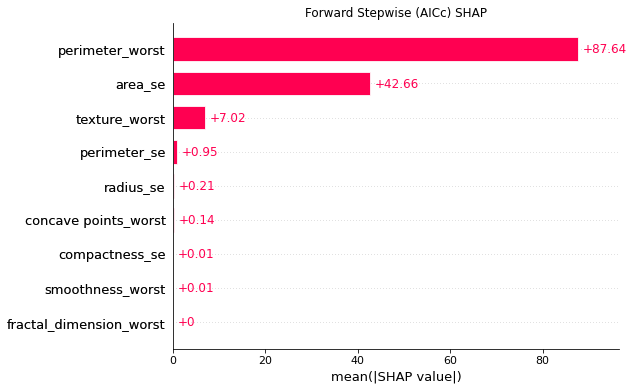

In [1544]:
fig = plt.figure()
model = FSLS_best_model
features_selected
features_selected = FSLS_features
final_classifier = model.named_steps["classifier"]

# Create the explainer
explainer = shap.Explainer(final_classifier,
                                   X_train[features_selected])
shap_values = explainer(X_hold_out[features_selected])

title = 'Forward Stepwise (AICc) SHAP'
plt.title(title)
#shap.summary_plot(shap_values, features_selected, plot_type='dot')
shap.plots.bar(shap_values)

# Save the figure as an SVG image
#fig.savefig("FSbar.svg", format="svg")

# $\to$ Shaps

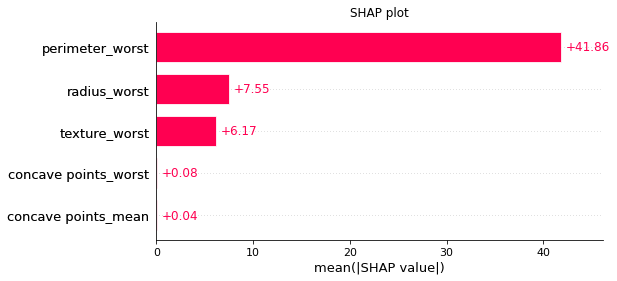

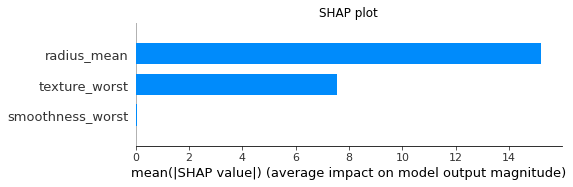

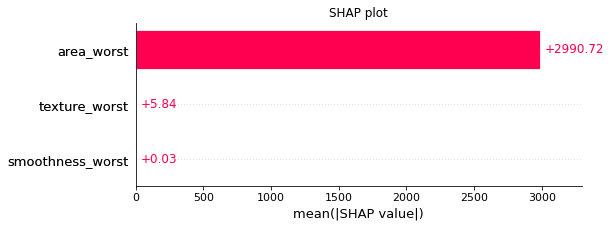

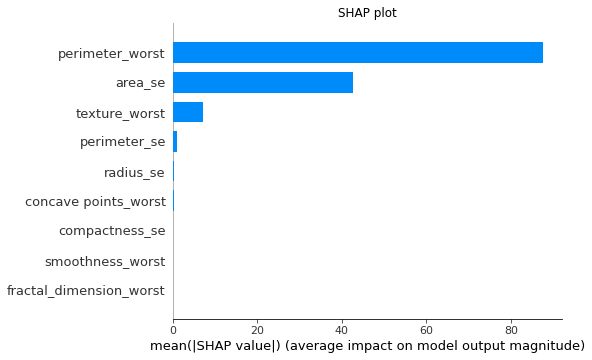

In [1503]:
Shaps = []
for model, features in zip([GraphLASSO_best_model, MMPC_best_model, FB_best_model, FSLS_best_model],
                           [GraphLASSO_features, MMPC_features, FB_features, FSLS_features]):
    Shaps.append(Shap(model, features))
Shaps = tuple(Shaps)

GLASSO_shap, MMPC_shap, FB_shap, FSLS_shap = Shaps

if __name__ == '__main__':
    GLASSO_shap.plot('bar_val')
    MMPC_shap.plot()
    FB_shap.plot('bar_val')
    FSLS_shap.plot()

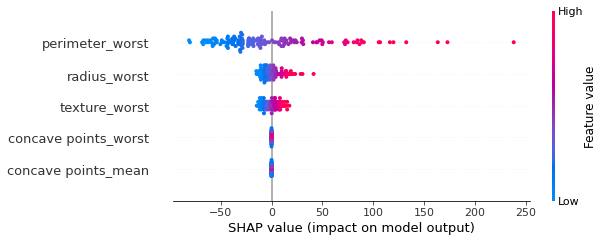

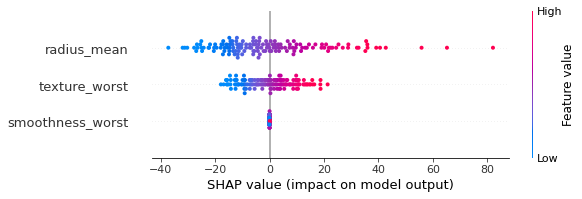

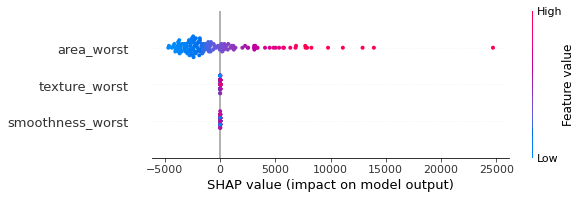

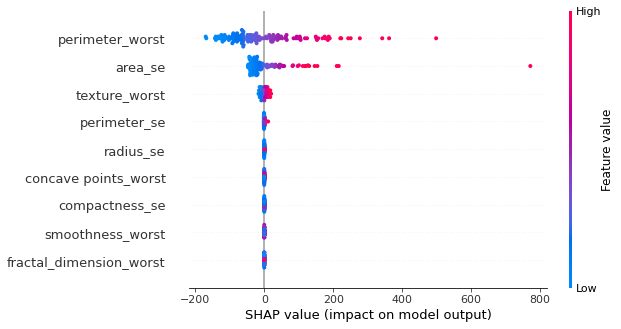

In [1369]:
if __name__ == '__main__':
    GLASSO_shap.plot('dot')
    MMPC_shap.plot('dot')
    FB_shap.plot('dot')
    FSLS_shap.plot('dot')

In [1151]:
glasso_shap_values = GLASSO_shap.values()
mmpc_shap_values = MMPC_shap.values()
fb_shap_values = FB_shap.values()
fsls_shap_values = FSLS_shap.values()


## We can compare the distribution of the SHAP values by calculating the mean absolute value (MAV)
glasso_mav = np.mean(np.abs(glasso_shap_values))
mmpc_mav = np.mean(np.abs(mmpc_shap_values))
fb_mav = np.mean(np.abs(fb_shap_values))
fsls_mav = np.mean(np.abs(fsls_shap_values))

## Then compare the MAV and choose the algorithm with the smallest MAV
MAV = {'Graphical Lasso':glasso_mav,
       'MMPC': mmpc_mav,
       'Forward-Backward':fb_mav,
       'Forward-stepwise':fsls_mav
      }

#print("The best algorithm is: ", best_algorithm)
MAV

{'Graphical Lasso': 11.139162096812983,
 'MMPC': 7.600892800977175,
 'Forward-Backward': 998.8630898087068,
 'Forward-stepwise': 15.404944155460642}

In [1368]:
best_algorithm = min(MAV, key=MAV.get)

if __name__ == '__main__':
    print(f"Based on mean absolute SHAP values: {best_algorithm} (close to GLASSO) seems the best") 

Based on mean absolute SHAP values: MMPC (close to GLASSO) seems the best


In [1198]:
#alternative way:


"""# You can compare the distribution of the SHAP values by calculating the median absolute deviation (MAD)
glasso_mad = np.median(np.abs(glasso_shap_values - np.median(glasso_shap_values)))
mmpc_mad = np.median(np.abs(mmpc_shap_values - np.median(mmpc_shap_values)))
fb_mad = np.median(np.abs(fb_shap_values - np.median(fb_shap_values)))
fsls_mad = np.median(np.abs(fsls_shap_values - np.median(fsls_shap_values)))

# You can then compare the MAD values and choose the algorithm with the smallest MAD value


MAD = {'Graphical Lasso':glasso_mad,
       'MMPC': mmpc_mad,
       'Forward-Backward':fb_mad,
       'Forward-stepwise':fsls_mad
      }

#print("The best algorithm is: ", best_algorithm)
MAD
"""
print()

# Plot the ROC curve

In [42]:
#The following function belongs to me.


def Roc_Auc(score: list, true_class: list, thresholds: list,show_info: bool = None, 
            show_ROC: bool = None, show_points: bool = None, model_i: str = '(best model)'): #sorted, reverse=True
    
    pred_given_threshold = lambda scr, t: list(map(lambda x: 1 if t<=x else 0, scr))

    predictions_t = np.array([pred_given_threshold(score, t) for t in thresholds])

    mult_true_class = np.array(true_class*len(thresholds)).reshape(len(thresholds),-1)
    
    
    tuplethem = lambda P,R: [(pred,real) for (pred,real) in zip(P,R)]
    true_pred_pairs = [tuplethem(p,r) for p,r in zip(predictions_t, mult_true_class)]
    
    TP = lambda D: D.count((1,1))
    TN = lambda D: D.count((0,0))
    FN = lambda D: D.count((0,1))
    FP = lambda D: D.count((1,0))

    POSclassProb = 0.5; NEGclassProb = 1 - POSclassProb #simply choice: the threshold that led to the max accuracy
    roc_points = [] ; Accuracies = []


    for i in range(len(thresholds)):
        f = lambda X: list(map(X, true_pred_pairs))
        tp = f(TP); tn = f(TN)
        fn = f(FN); fp = f(FP)

        TPR = tp[i]/(tp[i] + fn[i]); FPR = fp[i]/(fp[i] + tn[i])

        roc_points.append((FPR, TPR))

        conf_matrix = pd.DataFrame({
            'Pos': [tp[i], fn[i]],
            'Neg': [fp[i], tn[i]]
        }).T
        conf_matrix.columns = ['PP', 'PN']

        if show_info == True:
            print(f'\nfor threshold T={thresholds[i]}: ')
            print(f'TP = {tp[i]}')
            print(f'TN = {tn[i]}')
            print(f'FN = {fn[i]}')
            print(f'FP = {fp[i]}')
            print(f'sensitivity = TPR = {TPR}')
            print(f'1-specifisity = FPR = {FPR}')
            print(f'Accuracy = {TPR*POSclassProb + (1-FPR)*NEGclassProb}\n')
            print(f'Confusion  Matrix:\n\n {conf_matrix}\n')
            print(20*'___')

        Accuracies.append((TPR*POSclassProb + (1-FPR)*NEGclassProb, thresholds[i]))

    roc_points.sort() #in order to calc the auc later on
    

    max_acc = max(dict(Accuracies).keys())
    
    if show_info == True:
        print(f'max accuracy = {max_acc} for threshold T = {dict(Accuracies)[max_acc]}')
        
    x = list(map(lambda x: x[0], roc_points))
    y = list(map(lambda x: x[1], roc_points))


    #AUC
    AUC = auc(x,y) #one way
    
    AUC = roc_auc_score(true_class, score) #better way
    
    mark = '-'
    if show_ROC == True:
        mark = '.-'
        plt.plot(np.linspace(0,1,70),np.linspace(0,1,70),'--',
                 label='$\mathbf{Random}$ cls', alpha=0.3, color='red') # random classifier
        
        plt.plot(np.linspace(0,1,70),np.linspace(0,1,70),'--',
                 label='$\mathbf{Trivial}$ cls', alpha=0.3, color='orange') 
        
        plt.plot(x,y,mark, color=(0.25,0.65,1), markersize=7, label='$\mathbf{ROC}$')
        plt.fill_between(x,y, color='lightpink', alpha=0.1, label='$\mathbf{AUC}$')

        
        #view the points
        fix_number = lambda k: int(k) if k==int(k) else k
        
        if show_points:
            for i in range(len(roc_points)):
                plt.text(roc_points[i][0]-.034, roc_points[i][1]+.03,
                    f'({fix_number(float(format(roc_points[i][0],".1f")))},{fix_number(float(format(roc_points[i][1],".1f")))})', fontsize=7.4)

        plt.text(0.56,0.456,f'AUC = {AUC:.3f}', fontsize=14.3)

        plt.title('$\mathbf{ROC}$ curve '+model_i+' on $\mathbf{Hold}$-$\mathbf{Out}$-$\mathbf{Set}$', size=17)
        plt.xlabel('$1-$specifisity ($\mathbf{FPR}$)', size=16)
        plt.ylabel('sensitivity ($\mathbf{TPR}$)', size=16)
        plt.legend(loc="best")
            
        


In [24]:
final_model1 = GraphLASSO_best_model #based on AUC perf. on hold-out-set
final_model2 = MMPC_best_model #based on MAV on SHAP values

In [1634]:
y_pred1 = final_model1.predict(X_hold_out)
y_pred2 = final_model2.predict(X_hold_out)

y_true = y_hold_out

recall_scores = [recall_score(y_true, y_pred1, average='macro'),
                 recall_score(y_true, y_pred2, average='macro')]

precision_scores = [precision_score(y_true, y_pred1, average='macro'),
                    precision_score(y_true, y_pred2, average='macro')]

#Recall tp / (tp + fn)
#Precision tp / (tp + fp)
#macro f1: sum f1_i / n.

if __name__ == '__main__':
    print(f'Recall score for graphical lasso: {recall_scores[0]:.3f}') 
    print(f'Recall score for MMPC: {recall_scores[1]:.3f}')
    print(f'Precision score for graphical lasso: {precision_scores[0]:.3f}')
    print(f'Precision score for MMPC: {precision_scores[1]:.3f}')

Recall score for graphical lasso: 0.981
Recall score for MMPC: 0.961
Precision score for graphical lasso: 0.989
Precision score for MMPC: 0.964


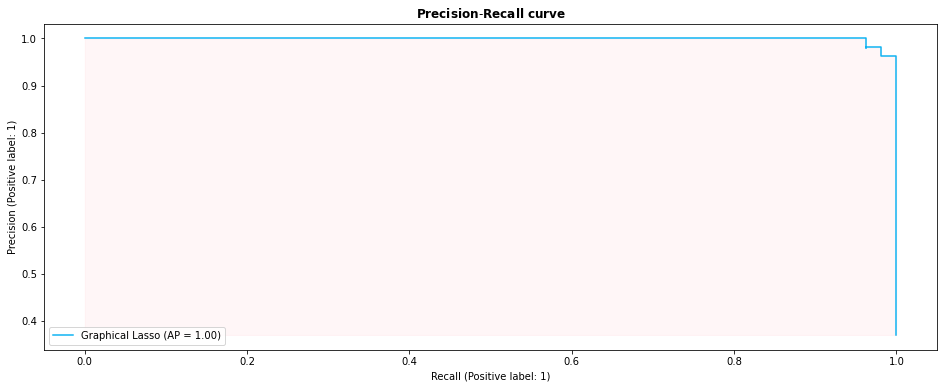

In [29]:
y_true = y_hold_out

y_scores = final_model1.predict_proba(X_hold_out)[:,1]

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)


display = PrecisionRecallDisplay.from_estimator(final_model1, X_hold_out, y_hold_out,
                                                name="Graphical Lasso", color=(0.05,0.7,0.95))
plt.fill_between(recall, precision, 0.37, alpha=0.115, color='lightpink')

_ = display.ax_.set_title("$\mathbf{Precision}$-$\mathbf{Recall}$ $\mathbf{curve}$")


In [30]:
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.9989481191777382


In [1650]:
F1_glasso = 2 * (precision_scores[0] * recall_scores[0]) / (precision_scores[0] + recall_scores[0])
print(f'F1-score -> {F1_glasso:.3f}')

F1-score -> 0.985


In [1579]:
final_model1

Pipeline(steps=[('Graph_LASSO', Kernel_Based_LASSO()),
                ('Scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1, random_state=69, solver='saga'))])

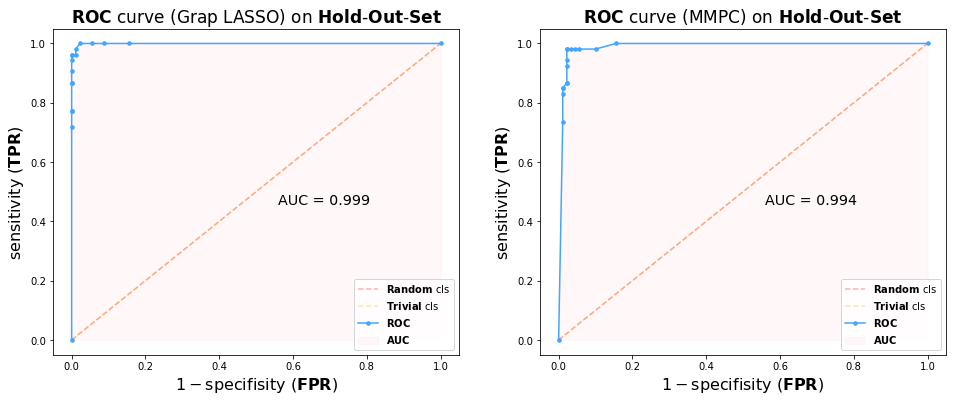

In [1295]:
score1 = list(final_model1.predict_proba(X_hold_out)[:,1])
true_class1 = np.array(np.ravel(y_hold_out),
                      dtype=int).tolist()
AUC1 = roc_auc_score(true_class1, score1) 


score2 = list(final_model2.predict_proba(X_hold_out)[:,1])
true_class2 = np.array(np.ravel(y_hold_out),
                      dtype=int).tolist()
AUC2 = roc_auc_score(true_class2, score2) 

thresholds = sorted(list(np.linspace(0,1,17)), reverse=True)


if __name__ == '__main__':
    plt.subplot(1, 2, 1) #1-row, 2-column goes to 1
    Roc_Auc(score1, true_class1, thresholds,
            show_ROC=True, show_points=False, model_i='(Graph LASSO)') # best model, on HOLD-OUT-set
    
    plt.subplot(1, 2, 2) #1-row, 2-column goes to 1
    Roc_Auc(score2, true_class2, thresholds,
            show_ROC=True, show_points=False, model_i='(MMPC)') # best model, on HOLD-OUT-set


# $\bullet$ Bootstrapping Confidence Intervals

In [1340]:
best_model = GraphLASSO_best_model


hold_out_set = pd.concat([X_hold_out, y_hold_out], axis=1)

bootstrapping_performances = []

for _ in range(666):
    Bootstrap_data = resample(hold_out_set)
    X_bootstrap = Bootstrap_data.iloc[:, Bootstrap_data.columns!='diagnosis']
    y_bootstrap = Bootstrap_data[['diagnosis']]

    auc_score = roc_auc_score(y_bootstrap, best_model.predict_proba(X_bootstrap)[:,1])

    bootstrapping_performances.append(auc_score)
    
    


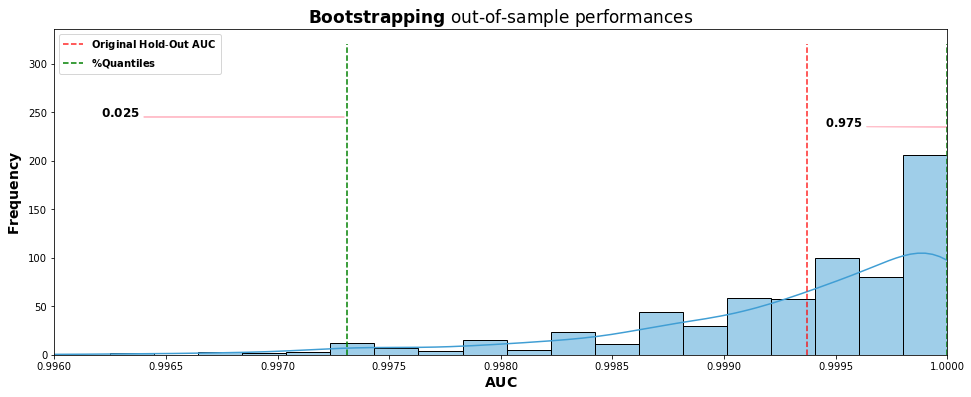

In [1453]:
q_25_perc = np.quantile(bootstrapping_performances, 0.025)
q_95_perc = np.quantile(bootstrapping_performances, 0.975)



if __name__ == '__main__':
    
    sns.histplot(bootstrapping_performances, kde=True, bins=33, color=(0.25,0.62,0.83), edgecolor='black')

    plt.plot([AUC1]*30,np.linspace(0,320,30),
             color='red', alpha=0.85, ls='--',
             label='$\mathbf{Original}$ $\mathbf{Hold}$-$\mathbf{Out}$ $\mathbf{AUC}$')

    plt.plot([q_25_perc]*35,np.linspace(0,320,35),
             color='green', ls='--',
             label='$\mathbf{\% Quantiles}$')


    plt.plot([q_95_perc]*35,np.linspace(0,320,35),
             color='green', ls='--')

    #arrow form (x, y) to (x+dx, y+dy).
    plt.arrow(0.99685, 245, 0,+0, width = 0.000043, head_width = 0.0009,color='pink')
    plt.text(0.99685-0.00064, 245+0.4, '$\mathbf{0.025}$', size=12)

    plt.arrow(0.999904, 235, +0.00295, -5, width = 0.00053, head_width = 0.0006,color='pink')
    plt.text(0.999904-0.00045, 235-0.05, '$\mathbf{0.975}$', size=11.5)

    plt.legend(loc='best')
    plt.title('$\mathbf{Bootstrapping}$ out-of-sample performances', size=17)
    plt.xlabel('$\mathbf{AUC}$', size=14)
    plt.ylabel('$\mathbf{Frequency}$', size=14)
    plt.xlim([0.996,1])


In [1367]:
if __name__ == '__main__':
    print(f'AUC Bootstrapping confidence interval -> ({q_25_perc:.5f}, {q_95_perc:.5f})')

AUC Bootstrapping confidence interval -> (0.99731, 1.00000)


In [1549]:
best_model.fit(X, y) #Train using all data this time.

Pipeline(steps=[('Graph_LASSO', Kernel_Based_LASSO()),
                ('Scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1, random_state=69, solver='saga'))])